<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>

# Financial Derivatives 

## Final Exam ##

* Yu-Ching Liao <ycliao3@illinois.edu>

# Basic Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Question 2

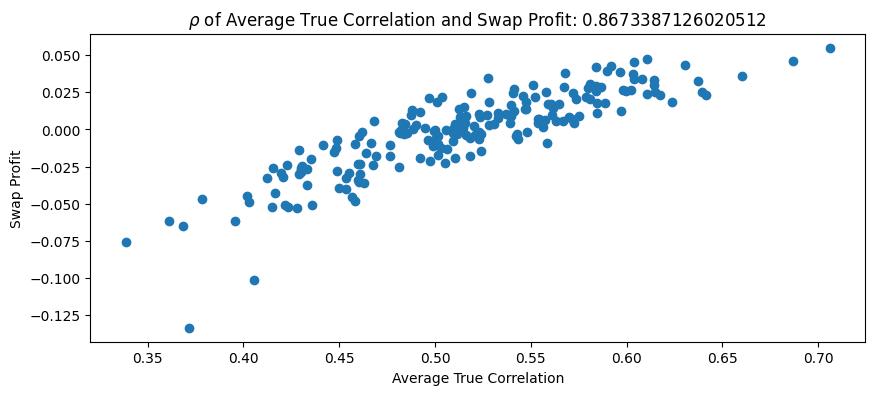

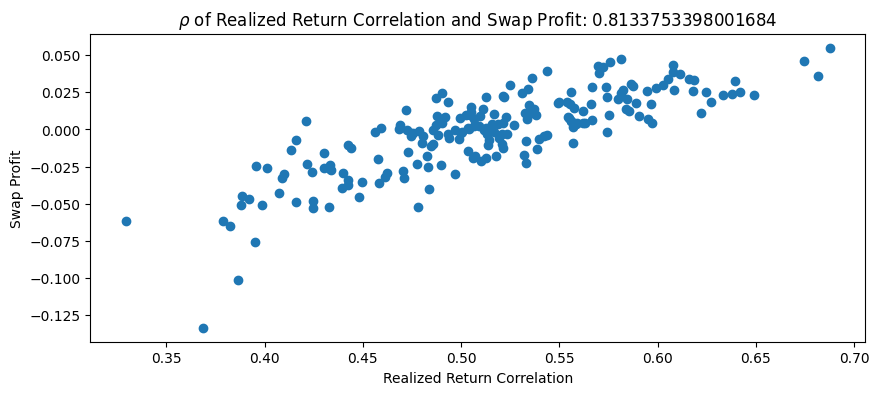

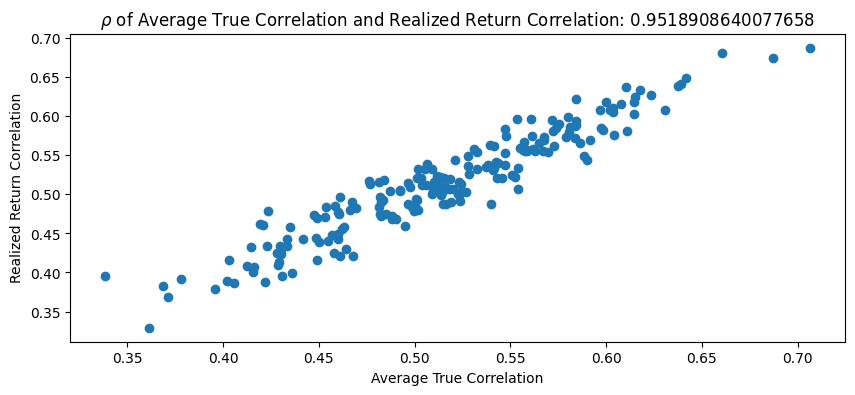

Breakeven correlation: 0.46830141809585857
Profit or loss with 0.10 higher correlation: $426783.12
Profit or loss with 0.10 lower correlation: $-1333622.48


In [2]:
# Parameters and initial values
T = 1/4
trading_days = 252
dt = 1/(24 * trading_days)
n_steps = int(T/dt)
n_sims = 200

mu_S = mu_M = 0.0
kappa_I = kappa_M = 2.0
b_I = b_M = 0.5
beta = 1.0
sigma_bar_I = 0.25
sigma_bar_M = 0.15
sigma_0_I = sigma_bar_I
sigma_0_M = sigma_bar_M

# Reproduction Setting
np.random.seed(42)

def simulate_system(n_steps, n_sims, dt):
    S = np.zeros((n_sims, n_steps))
    SM = np.zeros((n_sims, n_steps))
    sigma_I = np.zeros((n_sims, n_steps))
    sigma_M = np.zeros((n_sims, n_steps))
    rho = np.zeros((n_sims, n_steps))
    
    # Set initial values
    S[:, 0] = SM[:, 0] = 1.0
    sigma_I[:, 0] = sigma_0_I
    sigma_M[:, 0] = sigma_0_M
    rho[:, 0] = beta * sigma_0_M / np.sqrt(sigma_0_I**2 + (beta * sigma_0_M)**2)

    for i in range(1, n_steps):
        dW1 = np.random.normal(0, np.sqrt(dt), n_sims)
        dW2 = np.random.normal(0, np.sqrt(dt), n_sims)
        dW3 = np.random.normal(0, np.sqrt(dt), n_sims)
        dW4 = np.random.normal(0, np.sqrt(dt), n_sims)
        
        # Update sigma_I and sigma_M
        sigma_I[:, i] = sigma_I[:, i-1] + kappa_I * (sigma_bar_I - sigma_I[:, i-1]) * dt + b_I * sigma_I[:, i-1] * dW3
        sigma_M[:, i] = sigma_M[:, i-1] + kappa_M * (sigma_bar_M - sigma_M[:, i-1]) * dt + b_M * sigma_M[:, i-1] * dW4
        
        # Update S and SM
        S[:, i] = S[:, i-1] * (1 + mu_S * dt + sigma_I[:, i-1] * dW1 + beta * sigma_M[:, i-1] * dW2)
        SM[:, i] = SM[:, i-1] * (1 + mu_M * dt + sigma_M[:, i-1] * dW2)
        
        # Update rho
        rho[:, i] = beta * sigma_M[:, i] / np.sqrt(sigma_I[:, i]**2 + (beta * sigma_M[:, i])**2)

    return S, SM, sigma_I, sigma_M, rho

S, SM, sigma_I, sigma_M, rho = simulate_system(n_steps, n_sims, dt)

#Calculate swap profit, average true correlation, and realized return correlation
swap_profit = np.zeros(n_sims)
avg_true_corr = np.zeros(n_sims)
realized_return_corr = np.zeros(n_sims)
sigma_tilde_M = sigma_bar_M
sigma_tilde_S = np.sqrt(sigma_bar_I ** 2 + (beta * sigma_bar_M) ** 2)

for i in range(n_sims):
    r_S = (S[i, 1:] - S[i, :-1]) / S[i, :-1]
    r_SM = (SM[i, 1:] - SM[i, :-1]) / SM[i, :-1]
    realized_vol_S = np.sqrt(np.mean(r_S ** 2))
    realized_vol_M = np.sqrt(np.mean(r_SM ** 2))
    swap_profit[i] = np.sqrt((1/T) *np.sum(r_SM**2)) - sigma_bar_M - (np.sqrt((1/T) *np.sum(r_S**2)) - np.sqrt(sigma_bar_I**2 + (beta * sigma_bar_M)**2))
    avg_true_corr[i] = np.mean(rho[i, :])
    realized_return_corr[i] = np.corrcoef(r_S, r_SM)[0, 1]

#Scatter plots
plt.figure(figsize=(10, 4))
plt.scatter(avg_true_corr, swap_profit)
plt.title(f"$ρ$ of Average True Correlation and Swap Profit: {np.corrcoef(avg_true_corr, swap_profit)[0, 1]}")
plt.xlabel("Average True Correlation")
plt.ylabel("Swap Profit")
plt.show()

plt.figure(figsize=(10, 4))
plt.scatter(realized_return_corr, swap_profit)
plt.title(f"$ρ$ of Realized Return Correlation and Swap Profit: {np.corrcoef(realized_return_corr, swap_profit)[0, 1]}")
plt.xlabel("Realized Return Correlation")
plt.ylabel("Swap Profit")
plt.show()

plt.figure(figsize=(10, 4))
plt.scatter(avg_true_corr, realized_return_corr)
plt.title(f"$ρ$ of Average True Correlation and Realized Return Correlation: {np.corrcoef(avg_true_corr, realized_return_corr)[0, 1]}")
plt.xlabel("Average True Correlation")
plt.ylabel("Realized Return Correlation")
plt.show()


# Find the breakeven correlation
breakeven_index = np.argmin(np.abs(swap_profit))
breakeven_correlation = realized_return_corr[breakeven_index]
print(f"Breakeven correlation: {breakeven_correlation}")

# Find the profit or loss for correlations 0.10 higher/lower
higher_correlation_index = np.argmin(np.abs(np.array(realized_return_corr) - (breakeven_correlation + 0.10)))
lower_correlation_index = np.argmin(np.abs(np.array(realized_return_corr) - (breakeven_correlation - 0.10)))

higher_correlation_profit = swap_profit[higher_correlation_index] * 10e6
lower_correlation_profit = swap_profit[lower_correlation_index] * 10e6

print(f"Profit or loss with 0.10 higher correlation: ${higher_correlation_profit:.2f}")
print(f"Profit or loss with 0.10 lower correlation: ${lower_correlation_profit:.2f}")

# Question 3

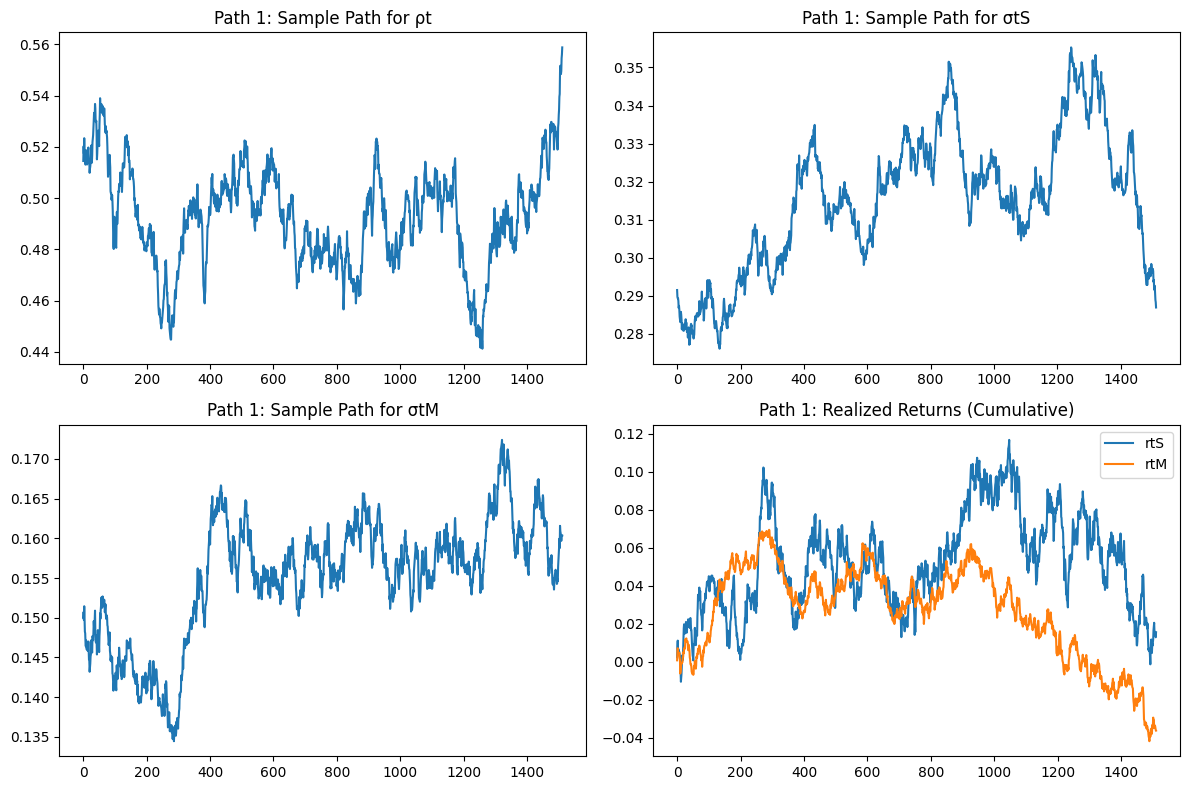

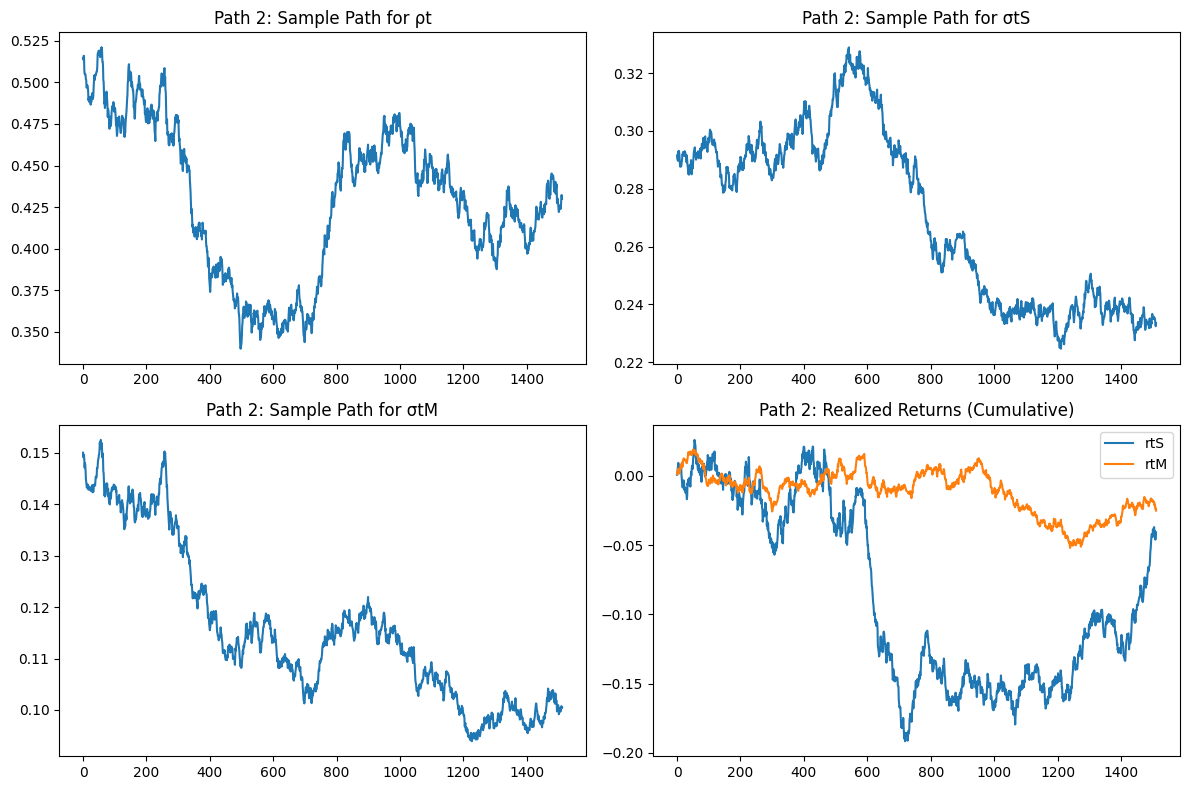

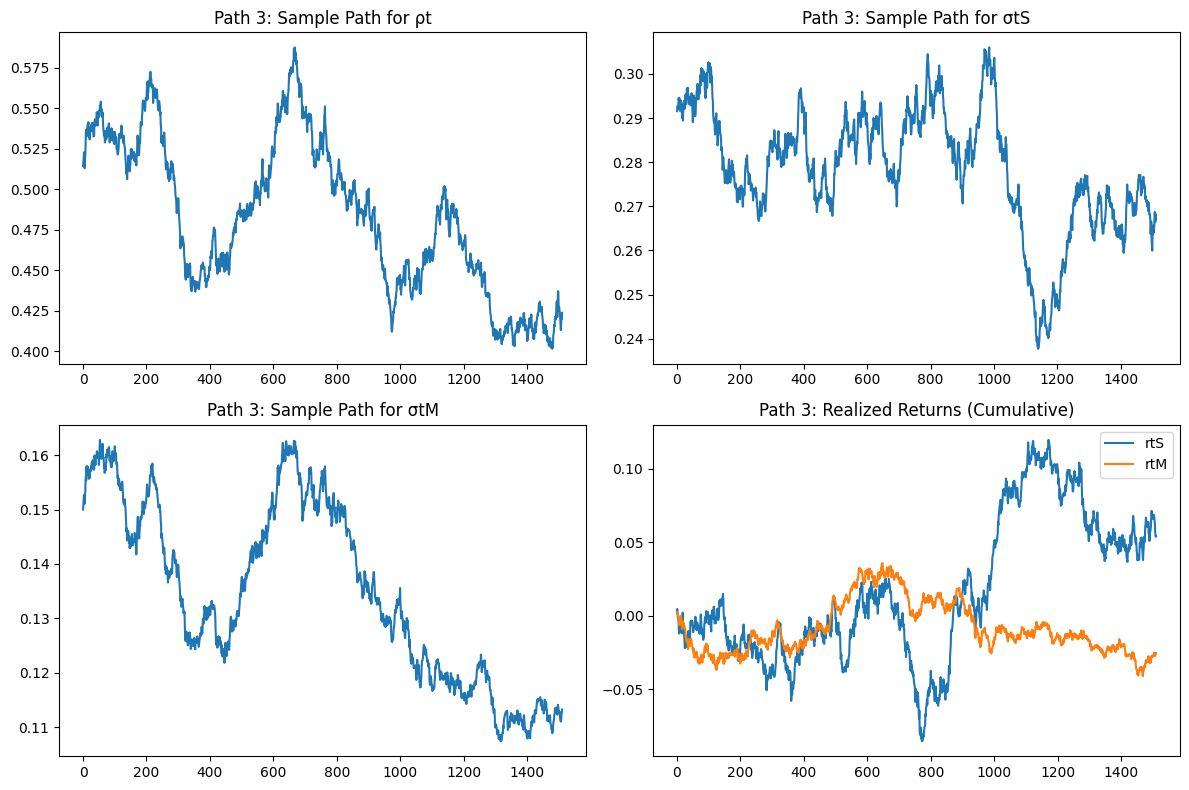

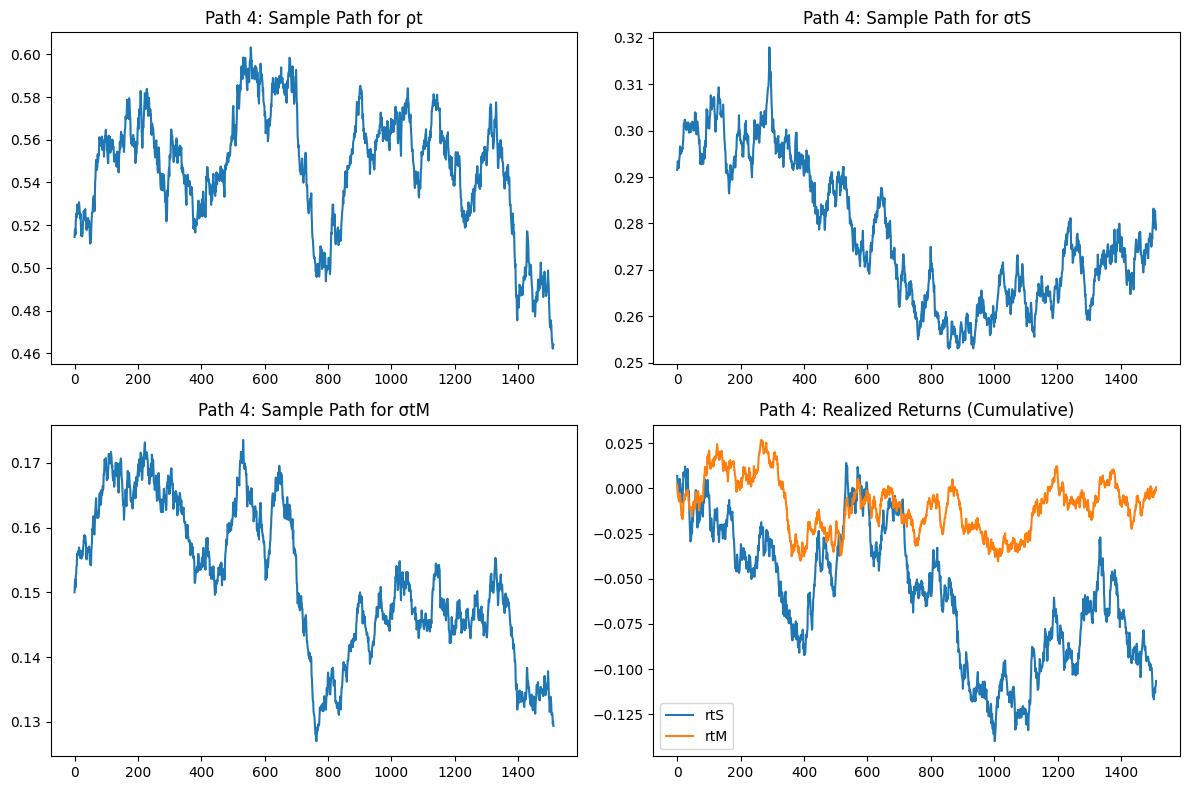

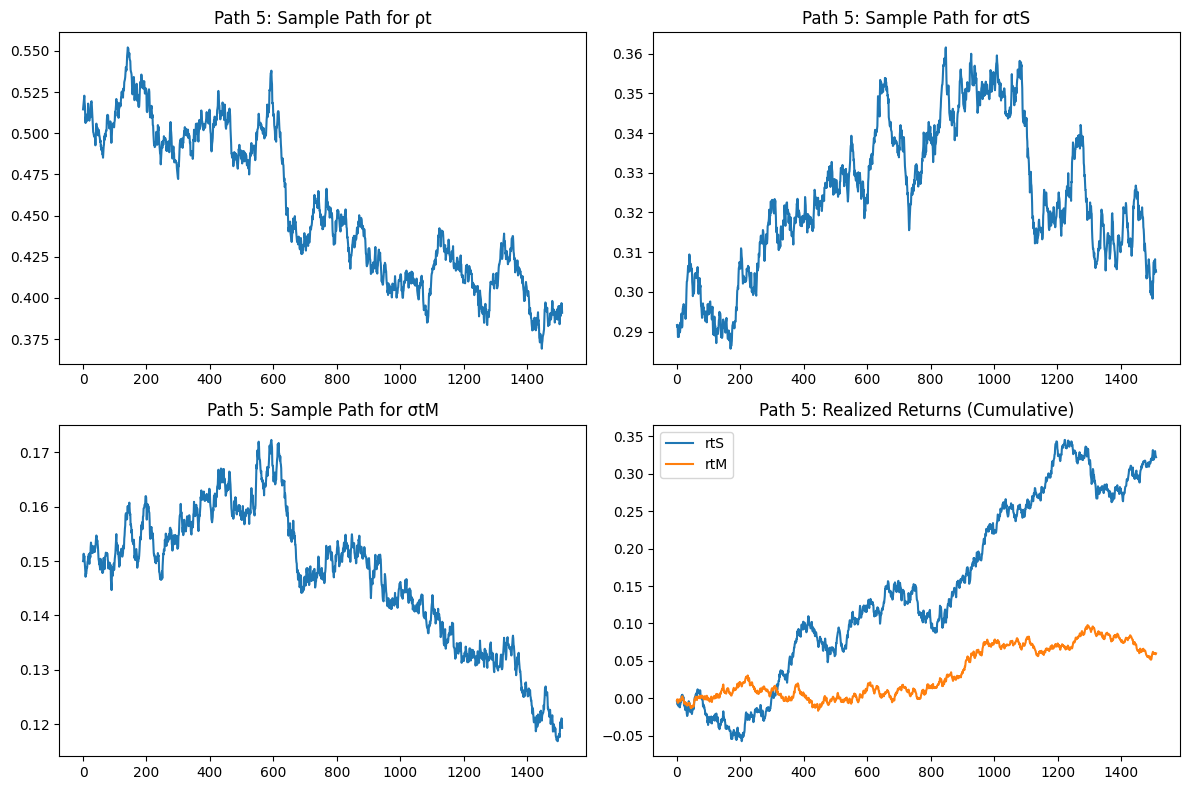

In [3]:
def plot_sample_paths(simulation_idx, S, SM, sigma_I, sigma_M, rho):
    r_S = (S[simulation_idx, 1:] - S[simulation_idx, :-1]) / S[simulation_idx, :-1]
    r_SM = (SM[simulation_idx, 1:] - SM[simulation_idx, :-1]) / SM[simulation_idx, :-1]
    sigma_S = np.sqrt(sigma_I[simulation_idx, :] ** 2 + (beta * sigma_M[simulation_idx, :]) ** 2)

    plt.figure(figsize=(12, 8))

    plt.subplot(221)
    plt.plot(rho[simulation_idx, :])
    plt.title(f"Path {simulation_idx+1}: Sample Path for ρt")

    plt.subplot(222)
    plt.plot(sigma_S)
    plt.title(f"Path {simulation_idx+1}: Sample Path for σtS")

    plt.subplot(223)
    plt.plot(sigma_M[simulation_idx, :])
    plt.title(f"Path {simulation_idx+1}: Sample Path for σtM")

    plt.subplot(224)
    plt.plot(np.cumsum(r_S), label="rtS")
    plt.plot(np.cumsum(r_SM), label="rtM")
    plt.title(f"Path {simulation_idx+1}: Realized Returns (Cumulative)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot sample paths for a specific simulation index (change the index to see different simulations)
for simulation_idx in range(5): 
    plot_sample_paths(simulation_idx, S, SM, sigma_I, sigma_M, rho)


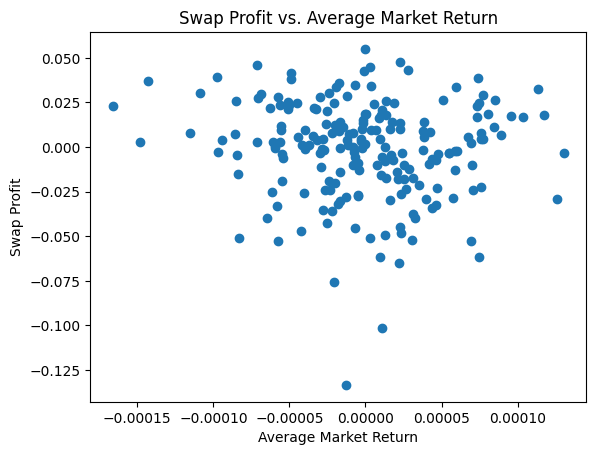

In [4]:
def plot_swap_profit_vs_market_return(S, SM, swap_profit):
    n_sims = S.shape[0]
    avg_market_return = np.zeros(n_sims)

    for i in range(n_sims):
        r_SM = (SM[i, 1:] - SM[i, :-1]) / SM[i, :-1]
        avg_market_return[i] = np.mean(r_SM)

    plt.scatter(avg_market_return, swap_profit)
    plt.xlabel("Average Market Return")
    plt.ylabel("Swap Profit")
    plt.title("Swap Profit vs. Average Market Return")
    plt.show()

plot_swap_profit_vs_market_return(S, SM, swap_profit)

# Question 4

In [6]:
import numpy as np

implied_vols = np.array([25, 45.1, 33.5, 28.3, 27.1, 18.3, 22.9, 22.1, 24.3])
realized_vols = np.array([25.7, 46, 32.4, 27.8, 24.7, 15.3, 20.9, 19.1, 20.6])
weights = np.ones(len(implied_vols)) / len(implied_vols)

weighted_avg_implied_vol = np.dot(weights, implied_vols)
weighted_avg_realized_vol = np.dot(weights, realized_vols)

spy_implied_vol = 22.8
spy_realized_vol = 20.1

spy_profit_loss = (spy_realized_vol - spy_implied_vol) * 10e6 /100
sector_profit_loss = (weighted_avg_realized_vol - weighted_avg_implied_vol) * 10e6 /100

net_profit_loss = spy_profit_loss - sector_profit_loss
print(f"Net profit/loss: ${net_profit_loss:,.2f}")


Net profit/loss: $-113,333.33


<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>